<a href="https://colab.research.google.com/github/JSJeong-me/LGE-PRI-1st/blob/main/8Team-patchcore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

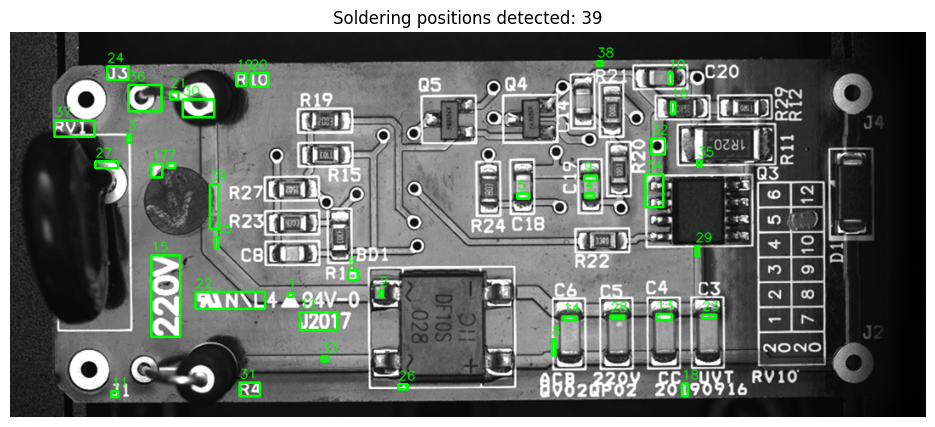

Saved overlay: /content/pcb_solder_detected.png
Saved CSV: /content/pcb_solder_positions.csv
Reusable script: /content/detect_solder_positions.py


In [1]:
# PCB soldering position detection demo
#
# This notebook cell loads the user's PCB image from /mnt/data/pcb.png,
# detects likely soldering pads/joints using classical CV (Top-hat + Otsu + morphology),
# filters candidates by geometric + photometric heuristics,
# and writes out:
#   - An overlay image with bounding boxes
#   - A CSV listing bounding box and centroid coordinates
#   - A reusable Python script you can run locally
#
# Outputs are saved under /mnt/data and previewed inline.

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from pathlib import Path

IMG_PATH = Path("/content/pcb.png")
assert IMG_PATH.exists(), f"Image not found at {IMG_PATH}"

# ---------- Load & preprocess ----------
img_bgr = cv2.imread(str(IMG_PATH))
if img_bgr is None:
    raise RuntimeError("Failed to load image.")

h0, w0 = img_bgr.shape[:2]
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Contrast enhancement for metallic highlights
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
eq = clahe.apply(gray)

# Top-hat to emphasize small bright regions (solder/metal tends to be reflective)
kernel_size = max(9, int(min(h0, w0) * 0.02))  # scale kernel to image size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
tophat = cv2.morphologyEx(eq, cv2.MORPH_TOPHAT, kernel)

# Binary mask (bright features) using Otsu
_, th = cv2.threshold(tophat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Morphology to connect fragmented pads
k_small = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, k_small, iterations=2)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, k_small, iterations=1)

# Optional: remove border darkness/lighting gradients via mask refinement
mask = opened.copy()

# ---------- Contour extraction ----------
cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

candidates = []
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    area = w * h
    if w == 0 or h == 0:
        continue
    aspect = w / h
    # geometric filters (quite permissive to keep IC pins & SMD ends)
    if not (4 <= w <= 220 and 4 <= h <= 120):
        continue
    if not (30 <= area <= 12000):
        continue
    # solidity / fill ratio to avoid hollow regions
    contour_area = cv2.contourArea(c)
    if area == 0:
        continue
    fill_ratio = contour_area / area
    if fill_ratio < 0.45:
        continue
    # photometric filter: solder/metal tends to be bright
    roi = gray[y:y+h, x:x+w]
    mean_intensity = float(np.mean(roi))
    if mean_intensity < 120:   # conservative threshold
        continue
    cx = x + w / 2.0
    cy = y + h / 2.0
    candidates.append({
        "x": int(x), "y": int(y), "w": int(w), "h": int(h),
        "cx": float(cx), "cy": float(cy),
        "area": int(area), "aspect": float(aspect),
        "fill_ratio": float(fill_ratio), "mean": float(mean_intensity)
    })

# ---------- Non-maximum suppression to merge overlaps ----------
def nms_boxes(boxes, overlap_thresh=0.3):
    if len(boxes) == 0: return []
    # boxes: [x,y,w,h]
    rects = np.array([[b["x"], b["y"], b["x"]+b["w"], b["y"]+b["h"]] for b in boxes], dtype=np.float32)
    scores = np.array([b["mean"] for b in boxes], dtype=np.float32)

    x1, y1, x2, y2 = rects[:,0], rects[:,1], rects[:,2], rects[:,3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)  # low to high

    pick = []
    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(last)

        xx1 = np.maximum(x1[last], x1[idxs[:-1]])
        yy1 = np.maximum(y1[last], y1[idxs[:-1]])
        xx2 = np.minimum(x2[last], x2[idxs[:-1]])
        yy2 = np.minimum(y2[last], y2[idxs[:-1]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[idxs[:-1]]
        idxs = idxs[np.where(overlap <= overlap_thresh)[0]]
    return [boxes[i] for i in pick]

final_candidates = nms_boxes(candidates, 0.3)

# ---------- Draw overlay ----------
overlay = img_bgr.copy()
for i, b in enumerate(final_candidates, start=1):
    x, y, w, h = b["x"], b["y"], b["w"], b["h"]
    cv2.rectangle(overlay, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(overlay, f"{i}", (x, max(0, y-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)

# save outputs
overlay_path = Path("/content/pcb_solder_detected.png")
csv_path = Path("/content/pcb_solder_positions.csv")
script_path = Path("/content/detect_solder_positions.py")

pd.DataFrame(final_candidates).assign(id=np.arange(1, len(final_candidates)+1)).to_csv(csv_path, index=False)

cv2.imwrite(str(overlay_path), overlay)

# ---------- Write reusable script ----------
script_code = f'''
import cv2, numpy as np, pandas as pd
from pathlib import Path

def detect_solder_positions(image_path: str,
                            output_overlay_path: str = "overlay.png",
                            output_csv_path: str = "solder_positions.csv",
                            min_mean_intensity: int = 120,
                            area_range=(30, 12000),
                            size_limits=((4, 220), (4, 120)),
                            nms_overlap=0.3):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise RuntimeError(f"Failed to load image: {{image_path}}")
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    h0, w0 = gray.shape[:2]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    eq = clahe.apply(gray)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (max(9, int(min(h0,w0)*0.02)),)*2)
    tophat = cv2.morphologyEx(eq, cv2.MORPH_TOPHAT, kernel)
    _, th = cv2.threshold(tophat, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    k_small = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, k_small, iterations=2)
    mask = cv2.morphologyEx(closed, cv2.MORPH_OPEN, k_small, iterations=1)

    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    (wmin, wmax), (hmin, hmax) = size_limits
    amin, amax = area_range

    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        area = w*h
        if not (wmin <= w <= wmax and hmin <= h <= hmax): continue
        if not (amin <= area <= amax): continue
        a = cv2.contourArea(c)
        if a/area < 0.45: continue
        mean_int = float(np.mean(gray[y:y+h, x:x+w]))
        if mean_int < min_mean_intensity: continue
        boxes.append({{"x": int(x), "y": int(y), "w": int(w), "h": int(h),
                       "cx": float(x+w/2), "cy": float(y+h/2),
                       "area": int(area), "aspect": float(w/max(h,1)), "mean": mean_int}})

    def nms(boxes, overlap_thresh):
        if len(boxes)==0: return []
        rects = np.array([[b["x"], b["y"], b["x"]+b["w"], b["y"]+b["h"]] for b in boxes], dtype=np.float32)
        scores = np.array([b["mean"] for b in boxes], dtype=np.float32)
        x1,y1,x2,y2 = rects[:,0],rects[:,1],rects[:,2],rects[:,3]
        areas = (x2-x1+1)*(y2-y1+1)
        idxs = np.argsort(scores)
        pick = []
        while len(idxs)>0:
            last = idxs[-1]
            pick.append(last)
            xx1 = np.maximum(x1[last], x1[idxs[:-1]])
            yy1 = np.maximum(y1[last], y1[idxs[:-1]])
            xx2 = np.minimum(x2[last], x2[idxs[:-1]])
            yy2 = np.minimum(y2[last], y2[idxs[:-1]])
            w = np.maximum(0, xx2-xx1+1)
            h = np.maximum(0, yy2-yy1+1)
            overlap = (w*h)/areas[idxs[:-1]]
            idxs = idxs[np.where(overlap <= overlap_thresh)[0]]
        return [boxes[i] for i in pick]

    final = nms(boxes, nms_overlap)
    # write outputs
    import pandas as pd
    df = pd.DataFrame(final).assign(id=np.arange(1, len(final)+1))
    df.to_csv(output_csv_path, index=False)

    overlay = img_bgr.copy()
    for i, b in enumerate(final, start=1):
        x,y,w,h = b["x"], b["y"], b["w"], b["h"]
        cv2.rectangle(overlay, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(overlay, str(i), (x, max(0, y-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
    cv2.imwrite(output_overlay_path, overlay)
    return df

if __name__ == "__main__":
    import argparse
    ap = argparse.ArgumentParser(description="Detect soldering pads/joints on a PCB image")
    ap.add_argument("--image", type=str, required=True, help="Path to input PCB image")
    ap.add_argument("--overlay", type=str, default="overlay.png", help="Path to save overlay PNG")
    ap.add_argument("--csv", type=str, default="solder_positions.csv", help="Path to save CSV")
    args = ap.parse_args()
    df = detect_solder_positions(args.image, args.overlay, args.csv)
    print(df.head())
'''
script_path.write_text(script_code, encoding="utf-8")

# ---------- Preview results ----------
fig = plt.figure(figsize=(12,5))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Soldering positions detected: {len(final_candidates)}")
plt.axis('off')
plt.show()

print(f"Saved overlay: {overlay_path}")
print(f"Saved CSV: {csv_path}")
print(f"Reusable script: {script_path}")


In [ ]:
!pip install torch torchvision opencv-python pandas numpy
# (선택) 빠른 NN 검색
!pip install faiss-cpu

In [16]:
!python /content/patchcore_solder_detect.py infer \
  --image PCB.png \
  --auto_seed \
  --out_dir ./out

[OK] Saved: out/overlay.png, out/heatmap.png, out/mask.png, out/points.csv
Detections: 14


In [19]:
# Patch 'patchcore_solder_detect.py' to be NumPy 2.0 compatible (replace arr.ptp() usage).
from pathlib import Path
import re, io, json

p = Path("/content/patchcore_solder_detect.py")
src = p.read_text(encoding="utf-8")

old_line = "heat = (255 * (sim_big - sim_big.min()) / (sim_big.ptp()+1e-8)).astype(np.uint8)"
if old_line in src:
    patched = src.replace(
        old_line,
        "denom = float(np.ptp(sim_big))\n    denom = denom if denom > 0 else 1e-8\n    heat = (255 * (sim_big - float(np.min(sim_big))) / denom).astype(np.uint8)"
    )
else:
    # Fallback: regex replace to catch whitespace variants
    pattern = re.compile(r"heat\s*=\s*\(255\s*\*\s*\(sim_big\s*-\s*sim_big\.min\(\)\)\s*/\s*\(sim_big\.ptp\(\)\s*\+\s*1e-8\)\)\.astype\(np\.uint8\)")
    patched = pattern.sub("denom = float(np.ptp(sim_big))\n    denom = denom if denom > 0 else 1e-8\n    heat = (255 * (sim_big - float(np.min(sim_big))) / denom).astype(np.uint8)", src)

p.write_text(patched, encoding="utf-8")

# Double-check: find remaining '.ptp()' usages
remaining = re.findall(r"\.ptp\(\)", patched)

print("Patched file saved at:", str(p))
print("Remaining '.ptp()' occurrences:", len(remaining))


Patched file saved at: /content/patchcore_solder_detect.py
Remaining '.ptp()' occurrences: 0


In [21]:
!python /content/patchcore_solder_detect.py infer \
  --image pcb.png \
  --auto_seed \
  --out_dir ./out

[OK] Saved: out/overlay.png, out/heatmap.png, out/mask.png, out/points.csv
Detections: 14
